(1001, 6) (6, 1001)


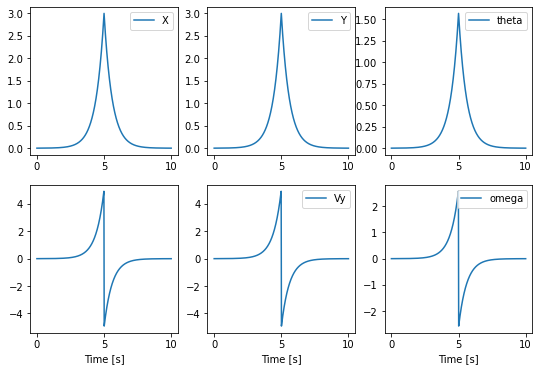

<Figure size 432x288 with 0 Axes>

In [2]:
from __future__ import print_function




import numpy as np
import matplotlib.pyplot as plt
import quadrotor
import math



robot = quadrotor.Quadrotor()
horizon_length = 1000
N = 1000
u_ = robot.mass*robot.g/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = (2*math.pi/10)/6
r = 1
T = 10
middle = 500
tau = 0.6


# x_desired = [math.cos(o*(T/N)*i) for i in range(0,N+1)]
# y_desired = [r*math.sin(o*(T/N)*i) for i in range(0,N+1)]
# vx_desired = [-r*o*math.sin(o*(T/N)*i) for i in range(0,N+1)]
# vy_desired = [ r*o*math.cos(o*(T/N)*i) for i in range(0,N+1)]
# theta_desried = [0 for i in range(0,N+1)]
# omega_desried = [0 for i in range(0,N+1)]



def generate_place(i):
    t = T/N*i
    return 3*math.e**(-abs(t-5)/tau)
def generateV(i):
    t = T/N*i
    if i<middle:
        return 3/tau*math.e**(-abs(t-5)/tau)
    elif i == middle:
        return 0
    else:
        return -3/tau*(math.e**(-abs(t-5)/tau))
def generate_theta(i):
    t = T/N*i
    return math.pi/2*math.e**(-abs(t-5)/tau)
def generate_omega(i):
    t = T/N*i
    if i<middle:
        return math.pi/2/tau*math.e**(-abs(t-5)/tau)
    elif i == middle:
        return 0
    else:
        return -math.pi/2/tau*math.e**(-abs(t-5)/tau)
    
x_desired = [generate_place(i) for i in range(N+1)]
vx_desired = [generateV(i) for i in range(N+1)]
y_desired = [generate_place(i) for i in range(N+1)]
vy_desired = [generateV(i) for i in range(N+1)]
theta_desried = [generate_theta(i) for i in range(N+1)]
omega_desried = [generate_omega(i) for i in range(N+1)]




state_desired = np.array([x_desired,vx_desired,y_desired,vy_desired,theta_desried,omega_desried])
ref_traj = state_desired.T
z0 = np.zeros_like(state_desired[:,0])
u_init = [(robot.mass * robot.g / 2) * np.ones([2]) for _ in range(horizon_length)]
print(ref_traj.shape,state_desired.shape)



t = [T/N*i for i in range(N+1)]
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_desired[1,:])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
import solver
try:
    import jax.numpy as np
except ImportError:
    import numpy as np

class iLQR_Track_Controller:
    def __init__(self,R,dt,use_autograd = False):
        self.aux = None
        self.R_ = R
        self.dt_ = dt

        #desired functions for plant dynamics and cost
        self.plant_dyn_ = None
        self.plant_dyn_dx_ = None
        self.plant_dyn_du_ = None

        self.cost_ = None
        self.cost_dx_ = None
        self.cost_du_ = None
        self.cost_dxx_ = None
        self.cost_duu_ = None
        self.cost_dux_ = None

        self.ilqr_ = None

        self.use_autograd=use_autograd
        return

    def build_iLQR_tracking(self,ref_pnts, weight_mats,obj):
        #obj must have next_state,  get_linearization
        self.obj = obj
        #figure out dimension
        self.T_ = len(ref_pnts)# leave the last point alone


        self.ref_array = np.copy(ref_pnts)
        self.weight_array = [mat for mat in weight_mats]
        #clone weight mats if there are not enough weight mats
        for i in range(self.T_ - len(self.weight_array)):
            self.weight_array.append(self.weight_array[-1])


        def tmp_cost_func(x, u, t, aux):
            err = x - self.ref_array[t]
            #autograd does not allow A.dot(B)
            cost = np.dot(np.dot(err, self.weight_array[t]), err) + np.sum(u**2) * self.R_
            return cost

        self.cost_ = tmp_cost_func
        self.ilqr_ = solver.Solver(T=self.T_ - 1, plant_dyn=self.plant_dyn_, cost=self.cost_,
                                   use_autograd=self.use_autograd)
        if not self.use_autograd:
            self.plant_dyn = lambda x, u, t, aux:obj.next_state(x,u,t)
            self.plant_dyn_du_ = lambda x, u, t, aux: obj.get_linearization(x, u, t)[0]
            self.plant_dyn_dx_ = lambda x, u, t, aux: obj.get_linearization(x, u, t)[1]
            def tmp_cost_func_dx(x, u, t, aux):
                err = x - self.ref_array[t]
                grad = np.concatenate([2 * err.dot(self.weight_array[t])])
                return grad

            self.cost_dx_ = tmp_cost_func_dx

            self.cost_du_ = lambda x, u, t, aux: 2 * self.R_ * u

            def tmp_cost_func_dxx(x, u, t, aux):
                hessian = np.zeros((self.obj.ns,self.obj.ns))
                hessian = 2 * self.weight_array[t]
                return hessian

            self.cost_dxx_ = tmp_cost_func_dxx

            self.cost_duu_ = lambda x, u, t, aux: 2 * self.R_ * np.eye(self.obj.nu)
            self.cost_dux_ = lambda x, u, t, aux: np.zeros((self.obj.nu,self.obj.ns))

            # build an iLQR solver based on given functions...
            self.ilqr_.plant_dyn = self.plant_dyn
            self.ilqr_.plant_dyn_dx = self.plant_dyn_dx_
            self.ilqr_.plant_dyn_du = self.plant_dyn_du_
            self.ilqr_.cost_dx = self.cost_dx_
            self.ilqr_.cost_du = self.cost_du_
            self.ilqr_.cost_dxx = self.cost_dxx_
            self.ilqr_.cost_duu = self.cost_duu_
            self.ilqr_.cost_dux = self.cost_dux_
        return

    def synthesize_trajectory(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.ilqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(self.obj.nu) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(self.obj.ns)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.ilqr_.LQR_solve(x_init, u_init)
        x_star = res_dict['x_array_star']
        Ks = res_dict['K_array_opt']
        ks = res_dict['k_array_opt']
        x_array_new, u_array_new = self.apply_control(x_star, u_init, ks, Ks,alpha=1)
        return x_array_new[:, 0:self.obj.nu]

    def get_rule(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.ilqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(self.obj.nu) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(self.obj.ns)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.ilqr_.iLQR_iteration(x_init, u_init,n_itrs)
        # x_star = res_dict['x_array_star']
        # Ks = res_dict['K_array_opt']
        # ks = res_dict['k_array_opt']
        # xs = res_dict['x_array_opt']
        # us = res_dict['u_array_opt']
        return res_dict

    def controller(self,u,x,k_array,K_array):
        pass

    def apply_control(self, x_array, u_array, k_array, K_array,alpha=1) :
        x_new_array = [None] * len(x_array)
        u_new_array = [None] * len(u_array)
        x_new_array[0] = x_array[0]
        for t in range(self.T_ -1 ):
            u_new_array[t] = u_array[t] + alpha * (k_array[t] + K_array[t].dot(x_new_array[t]-x_array[t]))
            x_new_array[t+1] = self.obj.next_state(x_new_array[t], u_new_array[t], t)
        return np.array(x_new_array), np.array(u_new_array)






In [3]:
weight_mats = [100*np.diag([60,5,40,5,50,1])*(math.e**(-abs(i-middle)/100)) for  i in range(len(ref_traj))]


ilqr_traj_ctrl = iLQR_Track_Controller(R=.01, dt=0.01)
ilqr_traj_ctrl.build_iLQR_tracking(ref_traj, weight_mats, robot)
x0 = ref_traj[0]
res = ilqr_traj_ctrl.get_rule(x0, u_init,n_itrs = 200, tol = 1)
x_array = res["x_array_opt"]
u_array = res["u_array_opt"]
k_array = res["k_array_opt"]
K_array = res["K_array_opt"]
def ilqr_controller(state,i):
    ut = K_array[i].dot(state-x_array[i]) + k_array[i] + u_array[i]
    return ut.T
t, state, u = robot.simulate(z0,ilqr_controller, horizon_length, disturbance = False)

Reject the control perturbation. Increase the regularization term.
Reject the control perturbation. Increase the regularization term.
Reject the control perturbation. Increase the regularization term.
Iteration (4,):	J = 1365281.993;	norm_k = 8.650;	reg = 1.000
Iteration (5,):	J = 998688.535;	norm_k = 6.453;	reg = 0.000
Iteration (6,):	J = 696809.885;	norm_k = 7.950;	reg = -1.000
Iteration (7,):	J = 590037.352;	norm_k = 11.410;	reg = -2.000
Reject the control perturbation. Increase the regularization term.
Reject the control perturbation. Increase the regularization term.
Reject the control perturbation. Increase the regularization term.
Reject the control perturbation. Increase the regularization term.
Reject the control perturbation. Increase the regularization term.
Iteration (13,):	J = 589103.852;	norm_k = 0.271;	reg = 2.000
Reject the control perturbation. Increase the regularization term.
Iteration (15,):	J = 587433.114;	norm_k = 0.410;	reg = 2.000
Reject the control perturbation

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAATRhtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA3vZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeFaUUfFqats62RlWMFYjFHqNBnasJX
DnwFWoRJxmonuUP3s5MFGir5eGYWrLXaUKH5YieGeCULeO0rUtmAZUCrs1RhIJINEWgItDYlkAlA
APZj7YljRCDhAd0bOrbkkey/yaZ7AlxAF9nLrgW3IQivHxJjDtAD4qc0uRqnHkZydOUH/mLt2p8i
m5eLYzT1xHpEX5neNAd7QaqnBRh8Wl9rI0GTKS/4Usx37EXTVyYv076PieDGfqx7cU1hzO1nwU+g
Nnsd2eLQ+mwF5MxHLtwp3y39j+HZBoabGP0JOaNZQqotuh6d2kjdkMiK/ZwQC4zoxp5BRBeLo4KJ
c22S5Cav+PY3ehQ6tAKuWX8b7EdG/zPaMUtO+YVOdqdygT4S3z6es9clXI2aH1N/lqQ+OF75RI+v
c7FbDuiOe2mH+XQ8/30JAmH4zwNHIWA+9GZlCDZyxsj0297b1pDx9u896IZkS5QPw9P/tS+fOL/v
gJ1zKAiFnv6gvP2K627ANIEtuSqzG0zufcuCNFu7J+JQT4I9E2uwAAE8DDSW7DITCAsBVhZyB68A
XYisRxULvi4ZczS0fdPWW6WdABogbMVPOtr5jsMnzmSukAtqzKCMVW9L+jzC9SZBZ/5enJMhCV+B
9LzNibTQVi/8vXyvHjWRaykQSGKGzy2qcnd+HHSaQ2/CE/raPlthvWh6c9eo7r/3glFoTmAkakWD
BYQTyJGvXK08RN7OqbDlHngS/Fc21PgZwIjg4Y4vGEgibm/IqJhncjRbSPzoD7NxrSR9BQD0QWfI
p8HA8rxizir6+ArNgzTTXDAi2CDWy/oN2xd4iYN6Rpf5Mhf1bx/9KgaTaUNZM3IRhh1BjZ/Cc7Le
7SNZ6nc3+jy4oI79eShfu74Jve8zVKPWMjSdwgx27lAAAAMAHVG/U3GwbvToNmjp/vlrCz3tmtQO
c8q2bv0FurP1Df7WuSdCmxBkwhU/J5qzpyx4jHbJSBwDLB2MPHmHFB/+tZ5rJuhYsc6UfBdhkob2
wy+5hfrvjmtDkEJNlfSWvgK0c/qf1zcV9TW6KcY7VwBJq0UXWCAEyNnNPMrilbrO52PUckIMnsQC
f/nxFwWAR2dotPE+BovjHn0b1QZCrjZo4K5vemFOfJ8Af/XSBkZoMHUhGvfIZRWTbpmlpUa0QVBz
XlI47J6jdpb3S8/3FL0wB9avcS+NH//xriECJynC0LjUrUe/n5Hsu01aLzr4mCncen/dN+V2sj6x
89kqPERCodDhwVB+dgaCuarc0pWnhDzHEvZfAAADAAD8OEVTdj/bRqq9lrQitvVALm1YaYtNZPrS
ZzbFnDSG22yWGxLB2/H7Ez7DCz364O1/WRmVFxIi//Tyr7MEtCpppOaaosYxyixJBVbijFlpH6py
dlMbRAsOX6+F7AaJ2/B/PDpTpi9px/dSj7afBI+cRntCHYeLrzoN3CIeYctENQtyv0hBQX+5xAOf
6x3NM75UP0GXOUY+iGFdIGTlqExIQIzJVaYrYt7tpxMBLGP9wXgwcIyIU+18z5z0UhT3wTYO32sa
huIx0Iy2KETihKJVBkohU4uftBPe/UXHfV/ckzKisjNpMbWkCASMpe6YPErM2bCvGazSePjtr4FR
lJeSSczq0jhk6lO8RdHd+TOASCEwBVaQp7yPsG4h7v94Rn6mDWuGiwA12lpDSFgeOCboluJu6b3s
TC4SkNh4lUFFXV1GfG8KUgTdeyhlDxE1aJ2JzZtWXIdCvZHa4xmadN/////HQPNKgFPzaKEop4ji
CEKdSynFi3h7DH4hp/ysHqNgGnqQfR7qz42QspqR0V0kLOI6a7AH+n2xHTOKtYZ9glPG5EhOmKQq
ZWAzON31Dj4OPw//cyH+t59MCdf0HMmIJFU4WkVE6LcR731obtwxnANIUzYsLwqLJklv3Dq6wx5C
9bx9AJF53tiXTYrzjt1HA1PtJTbC3mceREndsUcdp3XaJt00AAKyBoqsU6+9AAA3BfXDvlSuehHt
SoJB/LEOgOM2zsfuHDp5FxPf5QmOy9U3o76lSB0Zgtbz3bCr5+I7pB6d0gdj/m2sMXW82Qf8fLNn
g+8zIXcm/Ug2f34U1AaI+nn/ZQ0RXUcPVcmFCMN9trCuUKo6Hec7nCWR1Ye/n+ZOTBDnIvKz5Cv2
O08tmmfCo00k/ovJpGnI2MR4408VLJypcFaqCWWi1/f39lORBPn1O5sVLBwO32PpIozaxV8Ho6vy
3L07NP9pfuxJhX0BaRwCtbP/1qnaekGO3uwSGSd9SWalO+jxs3RTMUyDDE29RS+WlBL/yqnSWz5O
cCTgdrXrG619y4/j31/5z8qHvXOc4RkoFjCtkD3ZDjJPVQAAAwAAAwAE+28F0eh6pQj5YYRQRMtp
CqzI7+yHMPt+jbJpK+/6eIpX3kZUw/JKG+i8+z+vzJBAL1n37ZpysUM20mA4VVmn0Gu/J+7Xwzjl
MPoL7R8IK4DzA3LjVJmaubNqHCDoQw5dQyBvNR4JDE+dGJ6ljD/sdXm3yu62OP/HDqdoW4kB+MOI
Uf3gpfi810fHqSOPYpqhSNwHGGL42QspqRy6jWSnNTcr+3tKq9PaywmuWZhmDsCEeI5XMAKrf/yN
lA2ojVcfQMsZk9KD4pmLm

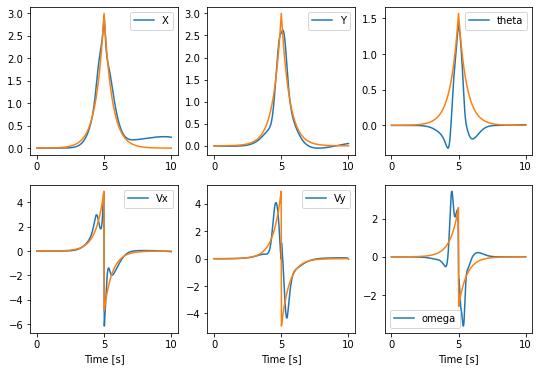

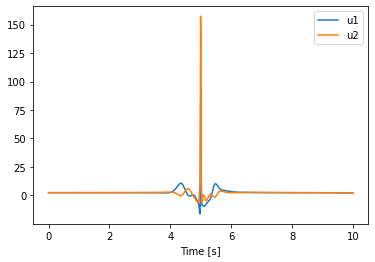

In [4]:



# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_desired[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
robot.animate_robot(state,u)
